# Counting distinct values

It's extremely common for analysts to want to count unique occurences of some dimension value in data. With the Druid database's history of large volumes of data comes an advanced computer science technique to speed up this calculation through approximation. In this tutorial, work through some examples and see the effect of turning it on and off, and of making it even faster by pre-generating the objects that Druid uses to execute the query.

## Prerequisites

This tutorial works with Druid 26.0.0 or later.

Launch this tutorial and all prerequisites using the `druid-jupyter` profile of the Docker Compose file for Jupyter-based Druid tutorials. For more information, see [Docker for Jupyter Notebook tutorials](https://druid.apache.org/docs/latest/tutorials/tutorial-jupyter-docker.html).

<details><summary>    
<b>Run without Docker Compose</b>    
</summary>

If you do not use the Docker Compose environment, you need the following:

* A running Druid instance.
* [druidapi](https://github.com/apache/druid/blob/master/examples/quickstart/jupyter-notebooks/druidapi/README.md), a Python client for Apache Druid. Follow the instructions in the Install section of the README file.
* [matplotlib](https://matplotlib.org/), a library for creating visualizations in Python,
* [pandas](https://pandas.pydata.org/), a data analysis and manipulation tool.
* Jupyter notebook or Jupyter Lab. See [jupyter.org](https://jupyter.org/) for installation instructions.

</details>

### Initialization

Run the next cell to attempt a connection to Druid services. If successful, the Druid version number will be shown in the output.

In [1]:
import druidapi
import os

if 'DRUID_HOST' not in os.environ.keys():
    druid_host=f"http://localhost:8888"
else:
    druid_host=f"http://{os.environ['DRUID_HOST']}:8888"
    
print(f"Opening a connection to {druid_host}.")
druid = druidapi.jupyter_client(druid_host)

display = druid.display
sql_client = druid.sql
status_client = druid.status

status_client.version

Opening a connection to http://druid-master-0.lan:8888.


'26.0.0'

### Load example flight data

Once your Druid environment is up and running, ingest the sample data for this tutorial.

Open the Druid console:

1. Load data
2. Batch - SQL
3. Example data
4. Select "FlightCarrierOnTime (1 month)"

For the purposes of this notebook, use all the defaults suggested by the console, including the default datasource name: 

`On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2005_11`

When this is completed, run the following cell for the final part of the initialization. This will provide us some methods to call.

In [2]:
import json
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

## COUNT(DISTINCT) queries on basic datasets

This is a typical query you might run to find the number of distinct Tail Numbers in the example dataset.

```sql
SELECT
    "Reporting_Airline",
    COUNT(DISTINCT "Tail_Number") AS "Events"
FROM "On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2005_11"
GROUP BY 1
ORDER BY 2
```

You're about to discover several ways enables you to arrive at this answer, each one having different performance characteristics depending on the needs of your users.

### Running COUNT(DISTINCT) with approximation

Druid automatically looks for query patterns that benefit from from approximation. In this instance, Druid identifies a match for approximate `COUNT(DISTINCT)`.

Each data server computes its own intermediate results for merging into the final result set. In a `COUNT(DISTINCT)` query, that means that they will create their own count inside a representation called a [data sketch](https://datasketches.apache.org/). These much smaller objects are then merged together when the query results are finalized, rather than Druid having to combine the individual lists of distinct values from each process.

This translates into much faster query execution, especially when the intermediate results are large – say when there are a lot of unique values in the source data.

It also means that the most scalable part of Druid – the individual data servers – do much more of the work, and do so earlier, instead of leaving it to the merge stage.

> Approximations improve scalability, storage, and memory use - at the cost of some error.
> 
> _[Gian Merlino](https://github.com/gianm)_

Run the following cell to plot the number of events in the sample data for each `Tail_Number`.

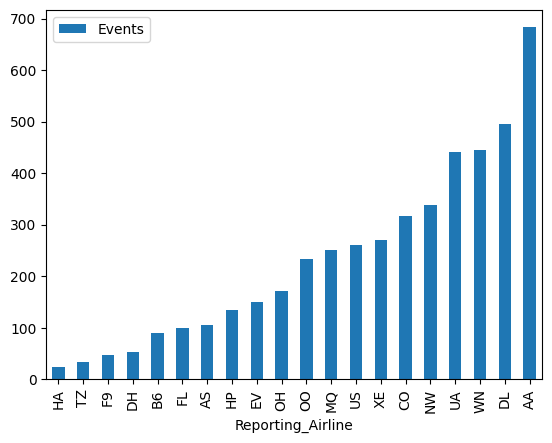

In [3]:
sql = '''
SELECT
    "Reporting_Airline",
    COUNT(DISTINCT "Tail_Number") AS "Events"
FROM "On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2005_11"
GROUP BY 1
ORDER BY 2
'''

df = pd.DataFrame(sql_client.sql(sql))

df.plot.bar(x='Reporting_Airline', y='Events')
plt.show()

### Running COUNT(DISTINCT) without approximation

We can supply a query context parameter, `useApproximateCountDistinct`, to force Druid to not use approximation. We won't get the speed boost afforded by the sketching approach – but that's OK because the example dataset is so small! It would be a different story if `Tail_Number` had high cardinality - like if it was IP Addresses or User Identifiers.

In [ ]:
sql='''
SELECT "Reporting_Airline", COUNT(DISTINCT "Tail_Number") AS "Events"
FROM "On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2005_11"
GROUP BY 1
ORDER BY 2
'''

req = sql_client.sql_request(sql)
req.add_context("useApproximateCountDistinct", "false")
resp = sql_client.sql_query(req)

df = pd.DataFrame(resp.rows)
df.plot.bar(x='Reporting_Airline', y='Events')
plt.show()

### Comparing approximate and non-approximate results

On the surface, these do not _look_ different. And, in a lot of user interfaces, that's perfectly fine!

The next cell will run the query in two modes – accurate and approximate. It then displays a `diff` between the two results.

In [ ]:
sql = '''
SELECT "Reporting_Airline", COUNT(DISTINCT "Tail_Number") AS "Events"
FROM "On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2005_11"
GROUP BY 1
ORDER BY 2
'''

req = sql_client.sql_request(sql)
req.add_context("useApproximateCountDistinct", "false")
resp = sql_client.sql_query(req)

df1 = pd.DataFrame(sql_client.sql(sql))
df2 = pd.DataFrame(resp.rows)

df3 = df1.compare(df2, keep_equal=True)
df3

There are _value_ errors, as you might expect with approximation. This therefore affects _ordering_ of results.

Error in sketch-based approximation is probabilistic, rather than guaranteed. That's to say that a certain percentage of the time you can expect the measurements you take to be within a certain distance of the true value. Also, their size is not dependent on the data – the default size of a sketch in Druid is just over 2000 bytes.

Approximation is especially helpful for very high cardinality data. When there are hundreds of thousands, millions, even tens-of-millions of distinct values, passing the individual distinct values to be merged takes longer and more data storage than using datasketches.

As an experiment, you may want to:

* Ingest or use a much larger data set
* Identify a high-cardinality column
* Issue an approximate `DISTINCT(COUNT)` with approximation turned on
* Issue another query with approximation turned off

## COUNT(DISTINCT) queries on sketched data

For even faster performance, we can provide Druid with compatible sketches inside the data itself. We do this at ingestion time, pre-populating some dimensions with the sketches that would otherwise have to be computed at query time.

This technique also massively reduces the footprint of the data in the database. By storing highly optimized representations of groups of unique values, you avoid storing the individual values themselves.

There are two types of Apache Datasketch that allow for `COUNT(DISTINCT)` computations:

* [HyperLogLog](https://druid.apache.org/docs/26.0.0/querying/sql-aggregations.html#hll-sketch-functions)
* [Theta](https://druid.apache.org/docs/26.0.0/querying/sql-aggregations.html#theta-sketch-functions)

A Theta sketch allows for set operations, like intersection and difference, while HyperLogLog ("HLL") does not.

To illustrate how this works, the next cell uses a `GROUP BY` query and generates a datasketch with a `DS_HLL` function.

In [ ]:
sql = '''
SELECT "Reporting_Airline", DS_HLL("Tail_Number") AS "Sketch"
FROM "On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2005_11"
GROUP BY 1
LIMIT 5
'''

display.sql(sql)

In our results, we get a "human readable" version of what a sketch looks like.

This is thanks to the [`DS_HLL`](https://druid.apache.org/docs/26.0.0/querying/sql-functions.html#ds_hll) function, which creates a HLL sketch. For a Theta sketch, we can use the [`DS_THETA`](https://druid.apache.org/docs/26.0.0/querying/sql-functions.html#ds_theta) function.

Each sketch represents, in a highly optimized format, the aggregated list of the `Tail_Number`s in the data set. Sketches are _mergable_ which is essential in a massively-parallelised query operation where individual microservices carry out individual calculations that must then be brought together to give a final result.

Imagine that our query is executed in parallel on all the data in the database – the sketches, like you see above, are then merged into a final sketch. When presented with the very final _merged_ datasketch, Druid uses the Apache Datasketch library to estimate how many distinct `Tail_Number`s there are in that set, and present the result back to us. This operation is on much less data, and requires much less CPU power than a non-approximate `COUNT(DISTINCT)`, where every row of our `GROUP BY` would have to be passed back to be merged.

### Creating sketches during batch ingestion

The next cell ingests the example flight data into a new table, `flights-counts`, and utilizes a `GROUP BY` to aggregate all the flight numbers into two sketches: a HLL sketch using `DS_HLL` and a Theta sketch using `DS_THETA`.

Notice that we no longer store the original field, `Tail_Number`. If we kept that field, the `GROUP BY` wouldn't aggregate any rows into the sketch - there would be a 1:1 relationship between the row and each `Tail_Number` - which is the opposite of what we are designing for! By implication, it will be no longer possible to use the raw data as part of any SQL queries, like `GROUP BY` or `WHERE`.

The `GROUP BY` below will generate a sketch _for each_ of the dimensions that we `GROUP BY` - having too many dimensions defeats the purpose of aggregating the data! Therefore the `SELECT` has been crafted to retain only the dimensions our imaginary end users will want to filter or `GROUP BY` the `COUNT(DISTINCT)` data on.

In [ ]:
sql='''
REPLACE INTO "flights-counts" OVERWRITE ALL
WITH "ext" AS (SELECT *
FROM TABLE(
  EXTERN(
    '{"type":"http","uris":["https://static.imply.io/example-data/flight_on_time/flights/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2005_11.csv.zip"]}',
    '{"type":"csv","findColumnsFromHeader":true}'
  )
) EXTEND ("depaturetime" VARCHAR, "arrivalime" VARCHAR, "Year" BIGINT, "Quarter" BIGINT, "Month" BIGINT, "DayofMonth" BIGINT, "DayOfWeek" BIGINT, "FlightDate" VARCHAR, "Reporting_Airline" VARCHAR, "DOT_ID_Reporting_Airline" BIGINT, "IATA_CODE_Reporting_Airline" VARCHAR, "Tail_Number" VARCHAR, "Flight_Number_Reporting_Airline" BIGINT, "OriginAirportID" BIGINT, "OriginAirportSeqID" BIGINT, "OriginCityMarketID" BIGINT, "Origin" VARCHAR, "OriginCityName" VARCHAR, "OriginState" VARCHAR, "OriginStateFips" BIGINT, "OriginStateName" VARCHAR, "OriginWac" BIGINT, "DestAirportID" BIGINT, "DestAirportSeqID" BIGINT, "DestCityMarketID" BIGINT, "Dest" VARCHAR, "DestCityName" VARCHAR, "DestState" VARCHAR, "DestStateFips" BIGINT, "DestStateName" VARCHAR, "DestWac" BIGINT, "CRSDepTime" BIGINT, "DepTime" BIGINT, "DepDelay" BIGINT, "DepDelayMinutes" BIGINT, "DepDel15" BIGINT, "DepartureDelayGroups" BIGINT, "DepTimeBlk" VARCHAR, "TaxiOut" BIGINT, "WheelsOff" BIGINT, "WheelsOn" BIGINT, "TaxiIn" BIGINT, "CRSArrTime" BIGINT, "ArrTime" BIGINT, "ArrDelay" BIGINT, "ArrDelayMinutes" BIGINT, "ArrDel15" BIGINT, "ArrivalDelayGroups" BIGINT, "ArrTimeBlk" VARCHAR, "Cancelled" BIGINT, "CancellationCode" VARCHAR, "Diverted" BIGINT, "CRSElapsedTime" BIGINT, "ActualElapsedTime" BIGINT, "AirTime" BIGINT, "Flights" BIGINT, "Distance" BIGINT, "DistanceGroup" BIGINT, "CarrierDelay" BIGINT, "WeatherDelay" BIGINT, "NASDelay" BIGINT, "SecurityDelay" BIGINT, "LateAircraftDelay" BIGINT, "FirstDepTime" VARCHAR, "TotalAddGTime" VARCHAR, "LongestAddGTime" VARCHAR, "DivAirportLandings" VARCHAR, "DivReachedDest" VARCHAR, "DivActualElapsedTime" VARCHAR, "DivArrDelay" VARCHAR, "DivDistance" VARCHAR, "Div1Airport" VARCHAR, "Div1AirportID" VARCHAR, "Div1AirportSeqID" VARCHAR, "Div1WheelsOn" VARCHAR, "Div1TotalGTime" VARCHAR, "Div1LongestGTime" VARCHAR, "Div1WheelsOff" VARCHAR, "Div1TailNum" VARCHAR, "Div2Airport" VARCHAR, "Div2AirportID" VARCHAR, "Div2AirportSeqID" VARCHAR, "Div2WheelsOn" VARCHAR, "Div2TotalGTime" VARCHAR, "Div2LongestGTime" VARCHAR, "Div2WheelsOff" VARCHAR, "Div2TailNum" VARCHAR, "Div3Airport" VARCHAR, "Div3AirportID" VARCHAR, "Div3AirportSeqID" VARCHAR, "Div3WheelsOn" VARCHAR, "Div3TotalGTime" VARCHAR, "Div3LongestGTime" VARCHAR, "Div3WheelsOff" VARCHAR, "Div3TailNum" VARCHAR, "Div4Airport" VARCHAR, "Div4AirportID" VARCHAR, "Div4AirportSeqID" VARCHAR, "Div4WheelsOn" VARCHAR, "Div4TotalGTime" VARCHAR, "Div4LongestGTime" VARCHAR, "Div4WheelsOff" VARCHAR, "Div4TailNum" VARCHAR, "Div5Airport" VARCHAR, "Div5AirportID" VARCHAR, "Div5AirportSeqID" VARCHAR, "Div5WheelsOn" VARCHAR, "Div5TotalGTime" VARCHAR, "Div5LongestGTime" VARCHAR, "Div5WheelsOff" VARCHAR, "Div5TailNum" VARCHAR, "Unnamed: 109" VARCHAR))
SELECT
  TIME_FLOOR(TIME_PARSE("depaturetime"), 'PT1H') AS "__time",
  "Reporting_Airline",
  "Origin",
  "Dest",
  COUNT(*) AS "Events",
  MAX("Distance") AS "Distance_Max",
  MIN("Distance") AS "Distance_Min",
  DS_HLL("Tail_Number") AS "Tail_Number_HLL",
  DS_THETA("Tail_Number") AS "Tail_Number_THETA"
FROM "ext"
GROUP BY 1, 2, 3, 4
PARTITIONED BY DAY
'''


When doing this programmatically we need to be sure to include a context parameter that prompts Druid to store the true sketch value: [`finalizeAggregations`](https://druid.apache.org/docs/26.0.0/multi-stage-query/reference.html#context-parameters). Notice that, if you build an ingestion using the console, these settings are applied for you automatically.

The following cell adds the parameters and then executes the ingestion.

In [ ]:
req = sql_client.sql_request(sql)
req.add_context("finalize", "false")
req.add_context("finalizeAggregations", "false")

sql_client.run_task(req)
sql_client.wait_until_ready('flights-counts')
display.table('flights-counts')

Open your Druid console's ingestion tab to monitor the progress of the ingestion.

Now we can use specific SQL functions that inform Druid to use sketches we have created:

* For HLL [`APPROX_COUNT_DISTINCT_DS_HLL`](https://druid.apache.org/docs/26.0.0/querying/sql-functions.html#approx_count_distinct_ds_hll), and
* for Theta [`APPROX_COUNT_DISTINCT_THETA`](https://druid.apache.org/docs/26.0.0/querying/sql-functions.html#approx_count_distinct_ds_theta).

Here's an example query showing our estimated results – notice that we can still use the `FILTER` clause to split results.

In [ ]:
sql='''
SELECT
   "Reporting_Airline",
   SUM("Distance_Max") AS "Miles_Flown",
   APPROX_COUNT_DISTINCT_DS_HLL("Tail_Number_HLL") FILTER (WHERE "Distance_Max" > 2000) AS "HLLApprox-over2k",
   APPROX_COUNT_DISTINCT_DS_THETA("Tail_Number_THETA") FILTER (WHERE "Distance_Max" < 2000) AS "ThetaApprox-under2k"
FROM "flights-counts"
GROUP BY 1
'''

display.sql(sql)

Remembering that HLL sketches are mergable, we can take multiple sets of results and estimate an overall distinct count.

In this query, we generate three HLL sketches covering flights out of three cities in the United States over a three week period. We then merge these together, and estimate how many distinct `Tail_Number`s there were.  You'll recognise the `APPROX_COUNT_DISTINCT_DS_HLL` function and the `DS_HLL` function, generating sketches for the `Tail_Number`s originating in each city. And to that we add the `HLL_SKETCH_UNION` function, which merges each of our result sets. To turn it from a sketch into something readable, we then use the `HLL_SKETCH_ESTIMATE` function to give us a number instead of a sketch.

We're then grouping those calculations by weeks by using `TIME_FLOOR`.

In [ ]:
sql='''
SELECT
  TIME_FLOOR("__time",'P1W') AS "Week commencing",
  APPROX_COUNT_DISTINCT_DS_HLL("Tail_Number_HLL") FILTER (WHERE "Origin"='ATL') AS "From Atlanta",
  APPROX_COUNT_DISTINCT_DS_HLL("Tail_Number_HLL") FILTER (WHERE "Origin"='DFW') AS "From Dallas",
  APPROX_COUNT_DISTINCT_DS_HLL("Tail_Number_HLL") FILTER (WHERE "Origin"='SFO') AS "From San Francisco",
  HLL_SKETCH_ESTIMATE(
     HLL_SKETCH_UNION(
       DS_HLL("Tail_Number_HLL") FILTER (WHERE "Origin"='ATL'),
       DS_HLL("Tail_Number_HLL") FILTER (WHERE "Origin"='DFW'),
       DS_HLL("Tail_Number_HLL") FILTER (WHERE "Origin"='SFO')
      )
    ) AS "From any of the three",
  APPROX_COUNT_DISTINCT_DS_HLL("Tail_Number_HLL") AS "From any city"
FROM "flights-counts"
WHERE TIMESTAMP '2005-10-31' <= __time AND __time <= TIMESTAMP '2005-11-20'
GROUP BY 1
'''

display.sql(sql)

### Creating sketches during streaming ingestion

In streaming ingestion, the same principles apply – you include an entry in the [`metricsSpec`](https://druid.apache.org/docs/26.0.0/ingestion/ingestion-spec.html#metricsspec) part of your ingestion specification, enabling [`queryGranularity`](https://druid.apache.org/docs/latest/ingestion/ingestion-spec.html#granularityspec) and `rollup` to truncate the time stamp and pre-aggregate the rows.

The statement above is equivallent to:

```json
    {
      "type": "HLLSketchBuild",
      "fieldName": "Tail_Number",
      "lgK": 12,
      "tgtHllType": "HLL_4"
    },
    {
      "type": "thetaSketch",
      "fieldName": "Tail_Number",
      "size": 16384
    }
```

Notice that here it's easy to see some internal parameters for sketch generation, like the `lgK` value for HLL. In SQL mode, these are exposed as supplementary parameters to the `DS_HLL` function. Be cautious of changing these values without researching the effects - not just in accuracy but also in terms of performance and segment size.

## Conclusion

* Approximation is the default execution model for `COUNT(DISTINCT)` queries
* You can turn it off with a query context parameter
* Accuracy is highly dependent on the distribution and cardinality of data across the database
* Druid can be pre-loaded with sketch objects that speed up approximation both in batch and streaming ingestion

## Learn more

* Watch [Employ Approximation](https://youtu.be/fSWwJs1gCvQ?list=PLDZysOZKycN7MZvNxQk_6RbwSJqjSrsNR) by Peter Marshall
* Read [Ingesting Data Sketches into Apache Druid](https://blog.hellmar-becker.de/2022/12/26/ingesting-data-sketches-into-apache-druid/) by Hellmar Becker
* Read more about the native "aggregator" functions for streaming ingestion
    * [ThetaSketch function](https://druid.apache.org/docs/26.0.0/development/extensions-core/datasketches-theta.html)
    * [HyperLogLog function](https://druid.apache.org/docs/26.0.0/development/extensions-core/datasketches-hll.html)